<img style ="float:right" src = "https://d1vwxdpzbgdqj.cloudfront.net/s3-public-images/learning-partners/greatlearning-brand.svg" width=15%>

# Case Study: Yelp restaurant Recommendation System

---------------
## Context
---------------

**Yelp** was founded in **2004** to help people find **great local businesses** like businesses, hairstylists, etc. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customers' **decision-making process**. Yelp uses automated software to recommend the **most helpful** and **reliable reviews** for the Yelp community out of such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across **4 countries**. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to hardware limitations.

-----------------
## Objective
-----------------

In this case study, we will build three types of recommendation systems: 
- **Knowledge/Rank Based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**


-----------------
## Dataset
-----------------

We will only use the following four attributes from the **yelp_reviews dataset**: 
- business_id
- business_name
- stars
- user_id

In [ ]:
# uncomment below code if you are using Google Colab to mount the drive

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# uncomment below code if you are using Google Colab to install the surprise package

#!pip install surprise

### **Importing Libraries**

In [ ]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

# from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.

### **Loading the data**

In [ ]:
#Importing the dataset.
yelp_review =pd.read_csv('/content/drive/MyDrive/yelp_reviews.csv', usecols=['user_id', 'business_id', 'business_name', 'stars'])
data=yelp_review.drop("business_name", axis=1)

Let's check the **info** of the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  229907 non-null  object
 1   stars        229907 non-null  int64 
 2   user_id      229907 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


- There are **2,29,907 observations** and **3 columns** in the data

### Data Exploration

**Let's start with the data exploration.**

**Print the top 5 rows of the dataset and describe the dataset.**  

In [ ]:
#printing the top 5 rows of the dataset
data.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,5,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,4,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,5,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,5,vYmM4KTsC8ZfQBg-j5MWkw


#### Describe the distribution of ratings

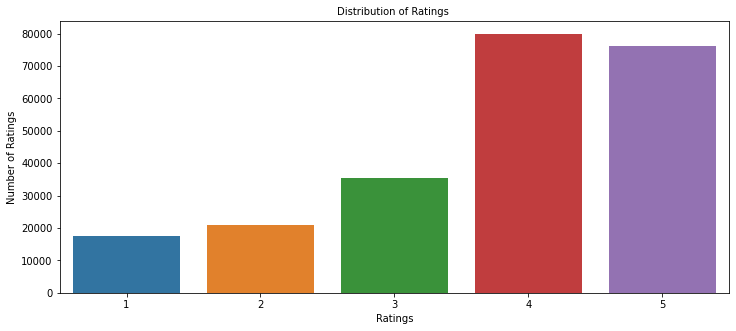

In [ ]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="stars", data=data)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**

* Data seems to be **highly skewed** towards Rating **'4' and '5'**. Rating **'5'** is the second-highest in the count and nearly the same as the number of 4 rating count. 

* We can see very few people are giving ratings **between 1 to 3**. It shows people tend to **not give a rating** for a restaurant that they **don't like**.

##### What is the total number of **unique users and unique restaurants**?

In [ ]:
#number of unique users
data['user_id'].nunique()

45981

In [ ]:
#number of unique restaurant 
data['business_id'].nunique()

11537

**Observations:**
- There are **45,981 unique users** in the dataset
- There are **11,537 unique restaurants** in the dataset
- As per the number of unique users and restaurants, there is a **possibility of 45981 * 11537 = ~53x10^7 ratings** in the dataset. But **we only have 2,29,907 ratings**, i.e. not every user has rated every restaurant in the dataset. And we can build a recommendation system to recommend a restaurant to users which they have not interacted with.

#### Is there any restaurant that has been interacted with more than once by the same user?

In [ ]:
data.groupby(['user_id', 'business_id']).count()

stars
user_id                business_id                  
--5hzxWLz5ozIg6OMo6tpQ Z3n01OZqARDv06QgBneOZw      1
--65q1FpAL_UQtVZ2PTGew -q_VodbABJygOSuv86LOtw      1
                       -sC66z4SO3tR7nFCjfQwuQ      1
                       0vzZ_Bcb02rJljeMU9XkBw      1
                       18TUn9oiW0k0yB6lheiOvw      1
...                                              ...
zztT9KKp0rmJRMeMl4CqzQ A8Khz3eeqIFFGaXurg3hxw      1
                       ilJiRYZgxjrEu2iexKu-pQ      1
                       sbsFamEj5wDxNAjUKrMcSw      1
                       wP5849J1DKB2KS3M6UwOAg      1
zzunUJtZqhcxDB3plnSFxg kuGQG_8i9P-4p9_Mym-G8Q      1

[229906 rows x 1 columns]

In [ ]:
data.groupby(['user_id', 'business_id']).count()['stars'].sum()

229907

- The **sum is equal to the total number of observations** which implies that **there is only interaction between a pair of restaurants and a user**.

#### Which restaurant is the **most reviewed restaurant** in the dataset?

In [ ]:
data['business_id'].value_counts()

hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
                         ... 
gR8LbrIuA1akOQ2bvnHenQ      3
jpgO5Mys3v6LtGk-diudtw      3
ifbMLSdB-VWs0wEN6UzBcQ      3
aO_3R3GnxhzCf0_PsyRJ6Q      3
6DaBdOr7NNsIWBC_2zty7A      3
Name: business_id, Length: 11537, dtype: int64

**Observations:**
- The **restaurant with business_id: hW0Ne_HTHEAgGF1rAdmR-g  has been interacted by most users** which is **844** times.
- But still, there is a possibility of **45981-844 = 45137** more interactions as we have **45981** unique users in our datasets. For those  **remaining users**, we can build a **recommendation system** to predict who is most likely to interact with this restaurant.

Also, out of these **844 interactions**, we need to consider the distribution of ratings as well to check whether this restaurant is the **most liked or most disliked restaurant**.

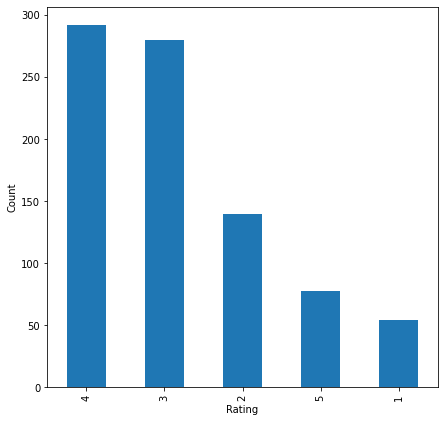

In [ ]:
#Plotting distributions of ratings for 844 interactions with given business_id 

plt.figure(figsize=(7,7))

data[data['business_id'] == "hW0Ne_HTHEAgGF1rAdmR-g"]['stars'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Observations:**
- We can see that **this restaurant not liked by the many of users**, as the count of ratings 3 and 4 is higher than the count of other ratings.
- There can be restaurants with very high interactions but the count of ratings **1 and 2** may be much higher than **4 or 5** which would imply that the restaurant is disliked by the majority of users.

#### Which **user interacted the most** with any restaurant in the dataset?

In [ ]:
data['user_id'].value_counts()

fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
                         ... 
KRi-7RSxU6jkw_1nXfpoow      1
wesv2JOGalpF1OALPoyZqw      1
-PJxXwkxu7vqV5Kz1WjyLA      1
pGEbIeS88E1mJ-G8zl6YBQ      1
fz_a0N_gYWhe3OmCU_C5lA      1
Name: user_id, Length: 45981, dtype: int64

**Observations:**
- The user with **user_id: fczQCSmaWF78toLEmb0Zsw** have interacted with the most number of restaurants i.e. **588** times. 
- But still, there is a possibility of **11537-588 =  10949** more interactions as we have **11537 unique restaurants** in our dataset. For those **10949** remaining restaurants, we can build a recommendation system to predict which restaurants are most likely to be reviewed by this user.

**As this dataset is very large and has 2,29,907 observations, it is not computationally possible to build a model using this. Moreover, there are many users who have only rated a few restaurants and also there are products which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumptions.**

Here, We will be taking users who have given at least 100 rating, as we prefer to have some number of rating of a product. 

In [ ]:
# Get the column containing the users
users = data.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1   

In [ ]:
# We want our users to have at least 100 ratings to be considred
RATINGS_CUTOFF = 100
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = data.loc[~data.user_id.isin(remove_users)]

**As we have now explored the data, let's start building Recommendation systems**

### Model 1: **Building Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend a restaurant to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use a rank-based recommendation system to recommend a restaurant to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each restaurant and then rank them based on their average rating.

In [ ]:
#Calculating average ratings
average_rating = data.groupby('business_id').mean()['stars']

#Calculating the count of ratings
count_rating = data.groupby('business_id').count()['stars']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [ ]:
final_rating.head()

,avg_rating,rating_count
business_id,,
--5jkZ3-nUPZxUvtcbr8Uw,4.545455,11
--BlvDO_RG2yElKu9XA1_g,4.162162,37
-0D_CYhlD2ILkmLR0pBmnA,4.000000,5
-0QBrNvhrPQCaeo7mTo0zQ,4.333333,3
-0bUDim5OGuv8R0Qqq6J4A,2.333333,6


Now, let's create a function to find the **top n restaurant** for a recommendation based on the average ratings of restaurant. We can also add a **threshold for a minimum number of interactions** for a restaurant to be considered for recommendation. 

In [ ]:
def top_n_restaurant(data, n, min_interaction=100):
    
    #Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get restaurant to recommend

##### Recommending top 5 restaurant with 50 minimum interactions based on popularity

In [ ]:
list(top_n_restaurant(final_rating, 5, 50))

['8HQ8clouLGgee99KkR4vXA',
 'CKjcewWeWvdJ7TzOQbZOIw',
 '97Z7j4vH0kfzL10AONi4uA',
 '_TekkyyFeX_8MBepPIxuTg',
 'L-uPZxooP_ziXCtRrWi8Pw']

**Now, that we have seen how to apply the Rank-Based Recommendation System, let's apply Collaborative Filtering Based Recommendation System**

### **Collaborative Filtering Based Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
 * User User Similarity Based  
 * Item Item similarity based
- Model based

#### Building a baseline user user similarity based recommendation system

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library
- Please use the following code to `install the surprise` library. You only do it **once** while running the code for the first time.

**!pip install surprise**

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

#### Before building the recommendation systems, let's go over some some basic terminologies we are going to use:

**Relevant item** - An item (product in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item** - An item that's **predicted rating is higher than the threshold (here 3.5) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### Some useful functions

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [ ]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    #Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

Below we are loading the **dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

In [ ]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'business_id', 'stars']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**, it is used to find the **desired similar items among a given set of items**.

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings**. 
- In the **present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**. 

### Model 2: **Building User-User Collaborative Filtering Model**

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

#KNN algorithm is used to find desired similar items.
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_user_user)

RMSE: 1.0409
Precision:  0.773
Recall:  0.417
F_1 score:  0.542


- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall - We are getting a **recall of almost 0.42**, which means out of **all the relevant restaurants 42% are recommended**. 
- Intuition of Precision - We are getting a **precision of almost 0.773**, which means **out of all the recommended restaurants 77% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.542**. It indicates that **mostly recommended restaurants were relevant and relevant restaurants were recommended**. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict rating for a user with `userId=rLtl8ZkDX5vH5nAx9C3q5Q` and `businessId=9yKzy9PApeiPPOUJEtnvkg`** as shown below.

In [ ]:
#predicting rating for a sample user with a visited restaurant.
sim_user_user.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui=5, verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

- The above output shows that **the actual rating for this user-item pair is 5 and the predicted rating is 3.77** by this **user-user-similarity-based baseline model**. This implies that the model is under-estimating the ratings.

Below we are **predicting rating for the same `userId=rLtl8ZkDX5vH5nAx9C3q5Q` but for a restaurant which this user has not seen yet i.e. `business_id=zp713qNhx8d9KCJJnrw1xA`** 

In [ ]:
#predicting rating for a sample user with a restaurant not-visited by the user.
sim_user_user.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.87   {'actual_k': 28, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.873369257511826, details={'actual_k': 28, 'was_impossible': False})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

Below we will be tuning hyperparameters for the `KNNBasic` algorithms. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.015276996904544
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above

Now let's build the **final model by using tuned values of the hyperparameters** which we received by using **grid search cross-validation**

In [ ]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state=1, verbose=False)

# training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0060
Precision:  0.762
Recall:  0.413
F_1 score:  0.536


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model has reduced a bit as compared to the baseline model.**

Let's us now **predict rating for a user with `userId`="rLtl8ZkDX5vH5nAx9C3q5Q", and business_id="9yKzy9PApeiPPOUJEtnvkg" with the optimized model as shown below**

In [ ]:
sim_user_user_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui=5, verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.90   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.9046318384360976, details={'actual_k': 16, 'was_impossible': False})

Below we are predicting rating for the same **`userId="rLtl8ZkDX5vH5nAx9C3q5Q"`** but for a restaurant which this user has **not visited before** i.e. `business_id=zp713qNhx8d9KCJJnrw1xA`, by using the **optimized model** as shown below - 

In [ ]:
sim_user_user_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.95   {'actual_k': 28, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.9506906733620437, details={'actual_k': 28, 'was_impossible': False})

## Identifying similar users to a given user (nearest neighbors)

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below we are finding the 5 most similar users to the first user in the list with internal id 0.

In [ ]:
sim_user_user_optimized.get_neighbors(0,5) #Here 0 is the internal id of the above user.

[18, 97, 201, 199, 40]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Below we will be implementing a function where the input parameters are - 

- data: a **rating** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
df_final.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
6,zp713qNhx8d9KCJJnrw1xA,5,wFweIWhv2fREZV_dYkz_1g
13,WGNIYMeXPyoWav1APUq7jA,4,Xm8HXE1JHqscXe5BKf0GFQ
18,b5cEoKR8iQliq-yT2_O0LQ,3,UsULgP4bKA8RMzs8dQzcsA
19,4JzzbSbK9wmlOBJZWYfuCg,4,nDBly08j5URmrHQ2JCbyiw


In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index='user_id', columns='business_id', values='stars')
    
    # extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

#### Predicted top 5 products for userId="rLtl8ZkDX5vH5nAx9C3q5Q" with similarity based recommendation system

In [ ]:
#Making top 5 recommendations for user_id "rLtl8ZkDX5vH5nAx9C3q5Q" with a similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_user_user)

In [ ]:
#Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,5
1,-7XuLxfYwZ9x72mEKXdv0A,5
2,-A82xEVAjOYZtDdRQw1FQw,5
3,-CZ78c-H3tTxpP-uQ09CWw,5
4,-J0jhpG0rv4saq9OMh8gXw,5


### Correcting the Ratings and Ranking the above products

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [ ]:
def ranking_products(recommendations, final_rating):
  # sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # merge with the recommended businesses to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['business_id', 'predicted_ratings']), on='business_id', how='inner')

  # rank the businesses based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # sort the businesses based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [ ]:
#Applying the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-J0jhpG0rv4saq9OMh8gXw,6,5,4.591752
2,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
3,-A82xEVAjOYZtDdRQw1FQw,5,5,4.552786
4,-CZ78c-H3tTxpP-uQ09CWw,3,5,4.422650


### Model 3: **Building Item Item Collaborative Filtering Model**

* Above we have seen **similarity-based collaborative filtering** where similarity has seen **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [ ]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

#KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_item_item)

RMSE: 1.0218
Precision:  0.663
Recall:  0.344
F_1 score:  0.453


- The baseline model is giving an F_1 score of **about 45%**. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId=rLtl8ZkDX5vH5nAx9C3q5Q` and `business_Id=9yKzy9PApeiPPOUJEtnvkg`** as shown below. Here the user has already interacted or watched the product with businessId "9yKzy9PApeiPPOUJEtnvkg".

In [ ]:
#predicting rating for a sample user with a visited restaurant.
sim_item_item.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui=5, verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.48   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.475, details={'actual_k': 40, 'was_impossible': False})

Below we are **predicting rating for the same `userId=rLtl8ZkDX5vH5nAx9C3q5Q` but for a restaurant which this user has not visited yet i.e. `business_id=zp713qNhx8d9KCJJnrw1xA`** 

In [ ]:
#predicting rating for a sample user with restaurant not visited by the user.
sim_item_item.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.77   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.775, details={'actual_k': 40, 'was_impossible': False})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

Below we will be **tuning hyperparameters for the `KNNBasic` algorithms**. Let's try to understand **some of the hyperparameters** of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0094078144114027
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation

In [ ]:
# using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=9, random_state=1, verbose=False)

# training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9986
Precision:  0.708
Recall:  0.375
F_1 score:  0.49


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is much better than the baseline model**. Also, there is a considerable fall in the RMSE value with tuning. Hence the tuned model is doing better than the earlier one.

Let's us now predict **rating for an user with `userId=rLtl8ZkDX5vH5nAx9C3q5Q` and for `business_id=9yKzy9PApeiPPOUJEtnvkg`** with the **optimized model** as shown below

In [ ]:
sim_item_item_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui=5, verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.90   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.896024464831805, details={'actual_k': 30, 'was_impossible': False})

- Here the optimized model is predicting a good rating (almost **4.90**) for the product whose actual rating is 5. 

Below we are **predicting rating** for the same **`userId=rLtl8ZkDX5vH5nAx9C3q5Q`** but for a restaurant which this user **has not interacted before** i.e. `business_id==zp713qNhx8d9KCJJnrw1xA`, by using the optimized model as shown below - 

In [ ]:
sim_item_item_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.71   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.705302758867788, details={'actual_k': 30, 'was_impossible': False})

- For an unknown product the model is predicting a rating of **3.71**.

#### Identifying similar users to a given user (nearest neighbors)

We can also find out **similar users** to a given user or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar users to the user with internal id 0 based on the `msd` distance metric

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

[21, 27, 35, 51, 57]

#### Predicted top 5 products for userId="rLtl8ZkDX5vH5nAx9C3q5Q" with similarity based recommendation system

In [ ]:
#Making top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_item_item_optimized)

In [ ]:
#Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,5Q49MxuWJgXS649i7i2Iow,4.416667
1,SmY_Xw31b2xyzsKbimQiHQ,4.346154
2,N6ff0yyo9Cv_7XPz-YDoow,4.308696
3,UmFnmIoLCRe1ywY0bzpRrQ,4.307692
4,p204PQg45gECcYwxCAK1wA,4.307692


In [ ]:
#Applying the ranking_products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,5Q49MxuWJgXS649i7i2Iow,10,4.416667,4.100439
0,SmY_Xw31b2xyzsKbimQiHQ,15,4.346154,4.087955
2,N6ff0yyo9Cv_7XPz-YDoow,7,4.308696,3.930731
3,UmFnmIoLCRe1ywY0bzpRrQ,4,4.307692,3.807692
4,p204PQg45gECcYwxCAK1wA,3,4.307692,3.730342


* Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### Model 4: **Building Model Based Collaborative Filtering Recommendation System - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

#### Building a baseline matrix factorization recommendation system

In [ ]:
# using SVD matrix factorization
svd = SVD(random_state=1)

# training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k =10.
precision_recall_at_k(svd)

RMSE: 0.9630
Precision:  0.77
Recall:  0.383
F_1 score:  0.512


- The baseline model with the algorithm is giving a nice F-1 score (almost **51%**). It indicates a good performance by the model.

- Let's now predict the rating for a user with **userId="rLtl8ZkDX5vH5nAx9C3q5Q"**` and **`business_id="9yKzy9PApeiPPOUJEtnvkg`** as shown below
- Here the user has already rated the product.

In [ ]:
#Making prediction.
svd.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui=5, verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.16   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.155179595069889, details={'was_impossible': False})

As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is also close to that. It seems like we have under-estimated the rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV

Below we are predicting rating for the same `userId=rLtl8ZkDX5vH5nAx9C3q5Q` but for a restaurant which this user has not seen before i.e. `business_id=zp713qNhx8d9KCJJnrw1xA`, as shown below - 

In [ ]:
#Making prediction. 
svd.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 4.09   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=4.09204353877637, details={'was_impossible': False})

We can see that the **estimated rating** for this **user-item pair** is ~4.10 based on this **matrix factorization based baseline model**

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting data
gs_.fit(data)

# best RMSE score
print(gs_.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.958163095054959
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above

Now we will **the build final model** by using **tuned values** of the hyperparameters which we received by using grid search cross-validation

In [ ]:
# building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# training the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(svd_optimized)

RMSE: 0.9507
Precision:  0.79
Recall:  0.402
F_1 score:  0.533


- We can see from above that the **tuned model** is showing a slightly better F_1 score than the baseline model, also the RMSE has gone down. Hence the tuned model is doing better than the earlier model.

Let's now predict a rating for a user with `userId=rLtl8ZkDX5vH5nAx9C3q5Q` and `BusinessId=9yKzy9PApeiPPOUJEtnvkg` with the optimized model as shown below

In [ ]:
#Using svd_algo_optimized model to recommend for userId "rLtl8ZkDX5vH5nAx9C3q5Q" and business_Id 9yKzy9PApeiPPOUJEtnvkg.
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui=5, verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.93   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.932454657847243, details={'was_impossible': False})

Here the predicted rating is godo here for a restaurant whose actual rating is **5**. The optimized model is giving a fairly good prediction.

In [ ]:
#Using svd_optimized model to recommend for userId "rLtl8ZkDX5vH5nAx9C3q5Q" and businessId "zp713qNhx8d9KCJJnrw1xA" which the user has not visited. 
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose=True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.97   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.971056550203264, details={'was_impossible': False})

For an unseen restaurant the rating given by the optimized model seems to be good. 

In [ ]:
#Getting top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, svd_optimized)

In [ ]:
#Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,X3icXUyW9vS4UXY6V_MR4w,79,4.789969,4.677460
1,97Z7j4vH0kfzL10AONi4uA,78,4.708755,4.595527
2,mQde7KRomOQoUyPGTqeXhA,34,4.730324,4.558825
3,XRBTHOXaJK_AJ2wy5mX_1A,26,4.754191,4.558075
4,4SviSw8uRF0ddj_HxUVnuA,10,4.731789,4.415561


### Conclusion

In this case study, we built recommendation systems using five different algorithms. They are as follows:
- rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering  

- We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.  
- To demonstrate **"user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been demonstrated. For these algorithms **grid search cross-validation is deployed to find the best working model**, and using that the **corresponding predictions are done**.

- **For performance evaluation** of these models **precision@k and recall@k** are introduced in this case study. Using these **two metrics F_1 score** is calculated for each working model.